In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


# System creation

In [2]:
import kwant
import tinyarray
import numpy as np
import scipy as spi
import scipy.constants as const
import scipy.signal as signal

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
print(const.e)

1.602176634e-19


In [3]:
a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
t = (const.hbar**2.)/(2.*0.023*const.m_e*(a*1e-10)**2.)/const.e*1000.
print(t)

4513.29322846401


In [4]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A

def make_system_real(L=1000., a=6.0583, m=0.023, alpha=100., mu=0., U_0=0., delta=0.1, B=0.2, phi=0., salt='chizhang'):
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    W = int(np.round(L/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    nu = alpha/a #https://arxiv.org/pdf/1205.1550.pdf
    print('Parameters: W, t, nu, mu, U_0, delta, B, phi, salt')
    print([W, t, nu, mu, U_0, delta, B, phi, salt])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[2, 0.4513293228464011, 0.16506280639783436, 0.0, 0.0, 0.1, 0.2, 0.0, 'chizhang']


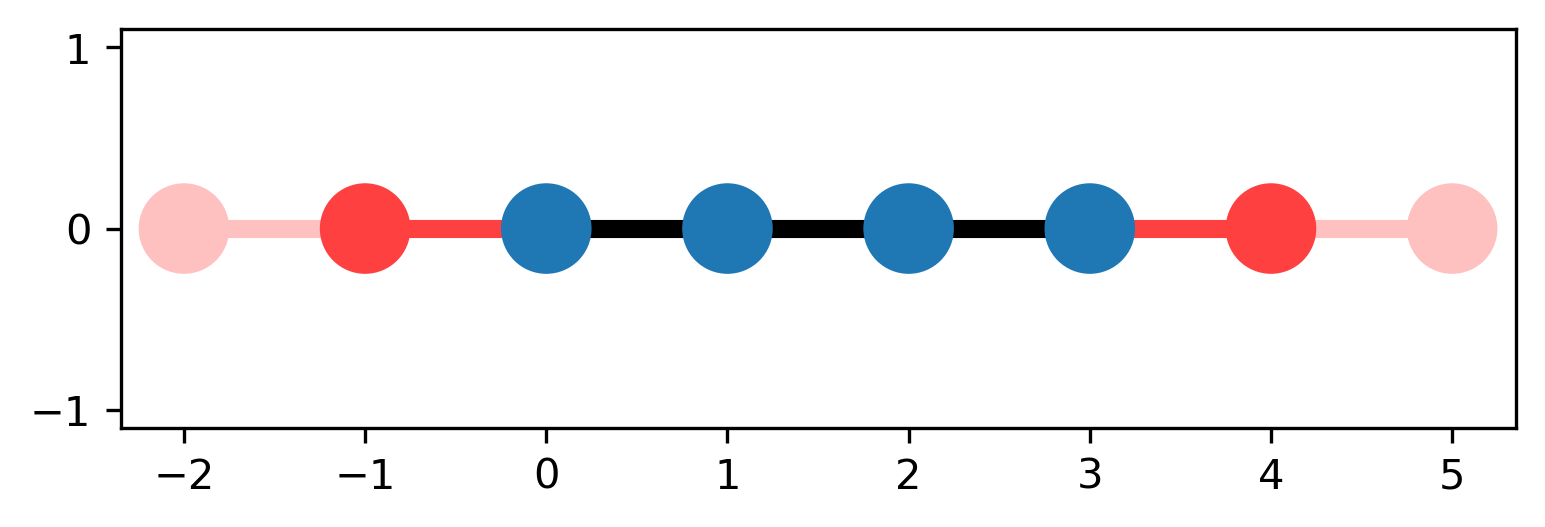

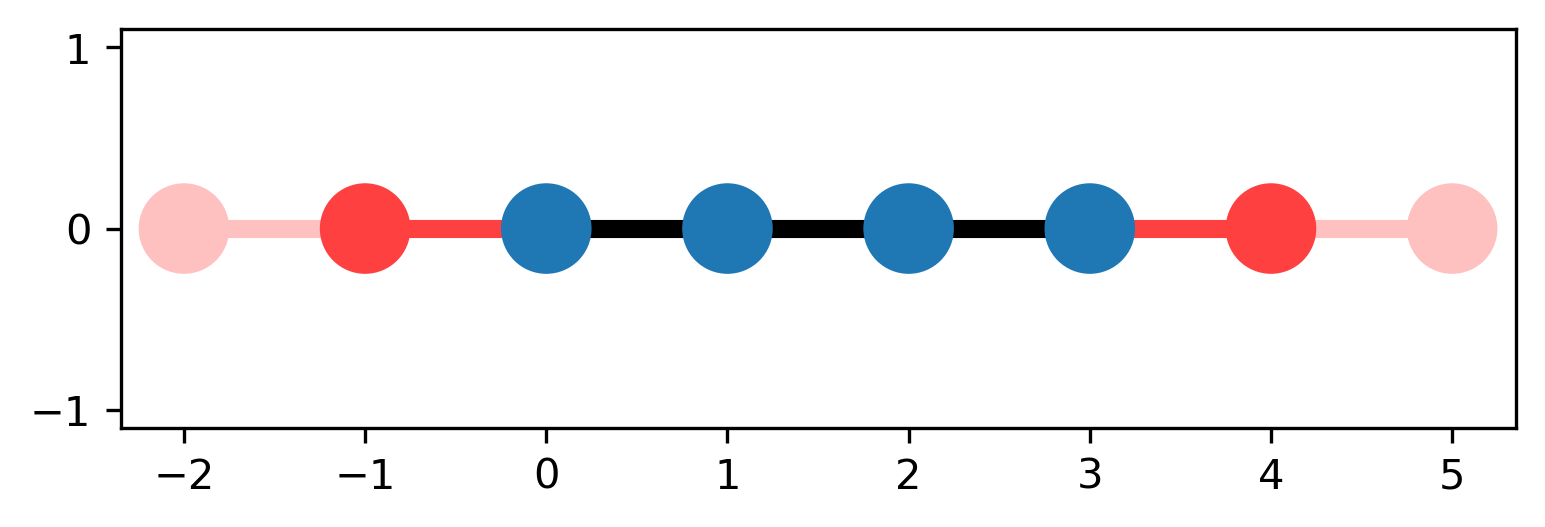

In [5]:
kwant.plot(make_system_real(B=0.2, delta=0.1, a=605.83), dpi=300)

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[17, 45.13293228464011, 1.6506280639783437, 0.2, 0.0, 0.1, 0.0, 0.0, 'chizhang']
Spectral gap:
0.1000000173971701
Fermi momentum
0.03939557187601572
Fermi wavelength:
159.48963317384485
(array([48210, 49373, 50627, 51790]),)
[[0.10000022 0.10000002 0.10000002 0.10000022]]
[0.11246902 0.03939557 0.03939557 0.11246902]


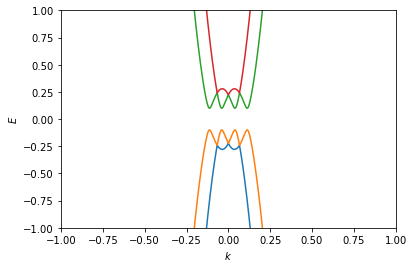

In [6]:
syst = make_system_real(B=0., a=60.583, mu=0.2)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
plt.xlabel(r'$k$')
plt.ylabel(r'$E$')
gap_energy = np.min(en[:,2])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.savefig('./Real params/dispersion a~60', dpi=300)

print('Spectral gap:')
print(np.min(en[:,2]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,2])])
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length

#try the scipy function
local_minima = signal.argrelextrema(en[:,2], np.less)
print(local_minima)
print(en[local_minima, 2])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))

In [45]:
syst = make_system_real(L=1000, a=60.583, B=0.0, mu=0., U_0=0., phi=0., salt='chizhang')
energies, wavefunctions = find_boundstates(syst, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[17, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']


In [46]:
print(energies)
print(wavefunctions.shape)

[-0.07585155 -0.07585155  0.07585155  0.07585155]
(76, 4)


In [10]:
def wavefunc_visualiser(psi, index, a=60.583):
    wavefunc = psi[:, index]
    orbitals = []
    for i in range(4):
        orbitals.append(wavefunc[i::4])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
    ax1.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[0])**2.)
    ax1.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax2.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[1])**2.)
    ax2.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax3.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[2])**2.)
    ax3.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax4.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[3])**2.)
    ax4.set(xlabel='Junction position/nm', ylabel='Probability density')
    
    for i in range(4):
        print(np.sum(np.abs(orbitals[i])**2.))

In [43]:
def wavefunc_phase_visual(psi, index, a=60.583):
    wavefunc = psi[:, index]
    wavefunc = wavefunc*np.exp(-1j*np.angle(wavefunc[0]))
    print(np.around(np.angle(wavefunc), 2))
    plt.plot(np.arange(len(wavefunc)), np.around(np.angle(wavefunc), 2)%3.14)
    plt.xlabel('orbital indices')
    plt.ylabel('relative phase')

[-0.   -0.    3.14  0.   -0.   -0.    3.14 -0.   -0.   -0.   -3.14 -0.
 -0.   -0.   -3.14 -0.   -0.   -0.   -3.14 -0.   -0.   -0.    3.14 -0.
 -0.   -0.   -3.14 -0.   -0.   -0.    3.14 -0.   -0.   -0.    3.14 -0.
  0.    0.    3.14 -0.   -0.   -0.    3.14 -0.   -0.   -0.    3.14 -0.
 -0.   -0.    3.14 -0.   -0.   -0.    3.14 -0.   -0.   -0.    3.14  0.
  0.   -0.    3.14 -0.   -0.   -0.    3.14 -0.    0.   -0.    3.14 -0.
 -0.   -0.    3.14 -0.  ]


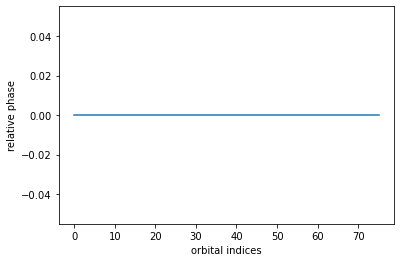

In [44]:
wavefunc_phase_visual(wavefunctions, 1)

0.01783991571401524
0.017839915713965315
0.024317025301112162
0.024317025301171906


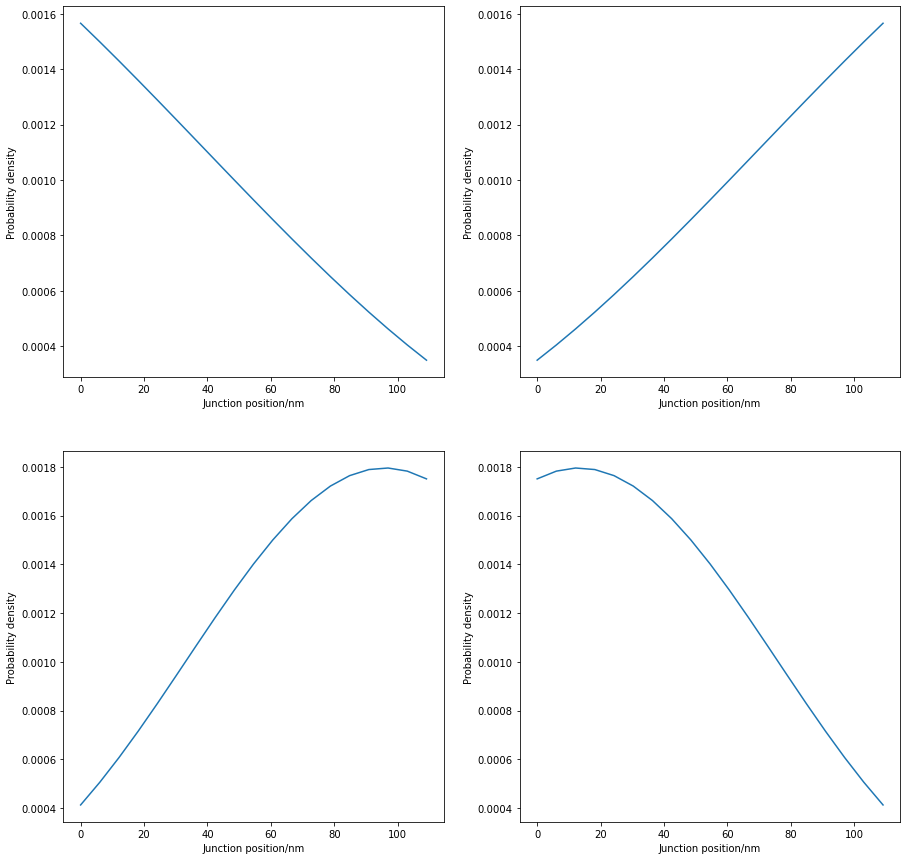

In [18]:
wavefunc_visualiser(wavefunctions, 1)
plt.savefig('./Istas testing/weston_ver', dpi=300)

#Validation: E vs L for diff a's.

# Test

## E vs phi

In [25]:
def phi_scan(L=1000, a=6.0583, B=0.2, mu=0., U_0=0., phi_array=[0, 4*np.pi], salt='chizhang'):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(phi_array[0], phi_array[1], 41):
        print(i)
        syst = make_system_real(L=L, a=a, B=B, mu=mu, U_0=U_0, phi=i, salt=salt)
        energies, wavefunctions = find_boundstates(syst, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [27]:
def phi_plot(energy_array, figure_title, delta=0.1, title=r'$L=1000, B=0, U_0=0, \mu=0, \Delta=0.1, salt=chizhang$'):
    ex=[]
    ey=[]
    
    phi = np.linspace(0, 4*np.pi, 41)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)
    plt.title(title)
    #plt.savefig('./Real params/'+figure_title, dpi=300)

In [ ]:
for i in range(61):
    plt.figure()
    phi_plot(e_phi_B[i], 'E vs phi gif, B=0p%s' % (i), title=r'$L=1000, B=%s, U_0=0, \mu=0, \Delta=0.1, salt=chizhang$' % (i/100))
    plt.axhline(np.array(e_B_gap[0])[i,1]/0.1, color='orange', label=r'$k=0$', linestyle=':')
    plt.axhline(-np.array(e_B_gap[0])[i,1]/0.1, color='orange', linestyle=':')
    plt.axhline(np.array(e_B_gap[0])[i,2]/0.1, color='red', label=r'$k=%.2f$' % e_B_gap[2][i], linestyle=':')
    plt.axhline(-np.array(e_B_gap[0])[i,2]/0.1, color='red', linestyle=':')
    plt.savefig('./Real params/E vs phi gif, B=0p%s' % (i), dpi=300)
    #plt.legend()

In [199]:
import pickle
pickle.dump(e_array7, open('./Real params/Data/E vs L, B=0p6', 'wb'))

In [ ]:
print(e_array)

In [ ]:
e_array, psi_array = phi_scan(B=0.)

In [ ]:
e_array1, psi_array1 = phi_scan(B=0.2)

In [ ]:
e_phi_B = []
for B in np.arange(0, 0.61, 0.01):
    print('B=')
    print(B)
    e, psi = phi_scan(B=B, a=60.583)
    e_phi_B.append(e)
print(e_phi_B)

In [39]:
#B from 1T
B = 2.*const.physical_constants['Bohr magneton'][0]/(const.e)*1000.
print(B)

0.11576763612070005


In [37]:
const.physical_constants['Bohr magneton']

(9.2740100783e-24, 'J T^-1', 2.8e-33)

## Validation of changing a for faster runtime

### E vs phi

In [ ]:
e_array_a, psi_array_a = phi_scan(B=0., a=60.583)

In [ ]:
e_array1_a, psi_array1_a = phi_scan(B=0.2, a=60.583)

In [ ]:
e_array2_a, psi_array2_a = B_scan(a=60.583)

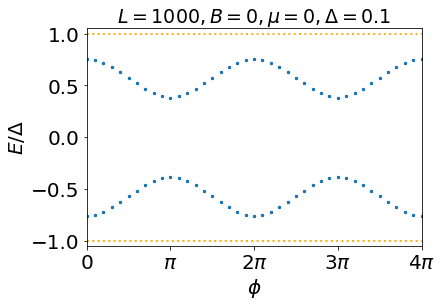

In [49]:
import pickle
e_phi_B = pickle.load(open('./Real params/Data/e_phi_B', 'rb'))
phi_plot(e_phi_B[0], 'sth')
plt.title(r'$L=1000, B=0, \mu=0, \Delta=0.1$', fontsize=19)
plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
plt.xlim(0, 4.*np.pi)
plt.ylim(-1.05, 1.05)
plt.axhline(e_B_gap[0][0]/0.1, color='orange', ls=':', alpha=0.9, lw=2)
plt.axhline(-e_B_gap[0][0]/0.1, color='orange', ls=':', alpha=0.9, lw=2)
#plt.axhline(e_B_gap[1][0]/0.1, color='r', ls=':', alpha=0.9, lw=2)
#plt.axhline(-e_B_gap[1][0]/0.1, color='r', ls=':', alpha=0.9, lw=2)
plt.savefig('./viva_plots/single subband trivial', dpi=300, bbox_inches='tight')

## E vs B

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

In [72]:
def B_scan(L=1000, a=6.0583, B_array=[0, 0.6], mu=0., U_0=0., phi=0., salt='chizhang'):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(B_array[0], B_array[1], 61):
        print(i)
        syst = make_system_real(L=L, a=a, B=i, mu=mu, U_0=U_0, phi=phi, salt=salt)
        energies, wavefunctions = find_boundstates(syst, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [14]:
def B_gap_scan(L=1000, a=6.0583, B_array=[0, 0.6], mu=0., U_0=0., phi=0., salt='chizhang'):
    band_gap_array = []
    for i in np.linspace(B_array[0], B_array[1], 61):
        print(i)
        syst = make_system_real(L=L, a=a, B=i, mu=mu, U_0=U_0, phi=phi, salt=salt)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,100001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
        print(np.min(en[:,2]))
    return np.array(band_gap_array)

In [9]:
def B_gap_scan(L=1000, a=6.0583, B_array=[0, 0.6], mu=0., U_0=0., phi=0., salt='chizhang'):
    band_gap_0_array = []
    band_gap_k_array = []
    kF_array = []
    for i in np.linspace(B_array[0], B_array[1], 61):
        print(i)
        syst = make_system_real(L=L, a=a, B=i, mu=mu, U_0=U_0, phi=phi, salt=salt)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,100001)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        local_minima = signal.argrelextrema(en[:,2], np.less)
        gaps = en[local_minima, 2]
        ks = np.linspace(-np.pi,np.pi,100001)[local_minima]
        band_gap_0_array.append(gaps[0][int((len(gaps[0])-1)/2)])
        band_gap_k_array.append(gaps[0][-1])
        kF_array.append(ks[-1])
        print(gaps)
        print(ks)
    return [band_gap_0_array, band_gap_k_array, kF_array]

In [8]:
def B_plot(energy_array, figure_title, gap_0=None, gap_k=None, B_range=[0, 0.61], delta=0.1, Bc=0.1, title=r'$L=1000, U_0=0, \mu=0, \phi=0, \Delta=0.1, salt=chizhang$'):
    ex=[]
    ey=[]
    B_array=np.arange(B_range[0], B_range[1], 0.01)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(B_array[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)/Bc
    ey = np.array(ey)/delta
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$B/B_C$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.ylim(-1, 1)
    plt.plot(B_array/Bc, gap_0/delta, c='orange', label=r'$\Delta_1$', linestyle='-.', lw=2)
    plt.plot(B_array/Bc, -gap_0/delta, c='orange', linestyle='-.', lw=2)
    plt.plot(B_array/Bc, gap_k/delta, c='red', label=r'$\Delta_2$', linestyle='-.', lw=2)
    plt.plot(B_array/Bc, -gap_k/delta, c='red', linestyle='-.', lw=2)
    plt.legend()
    #plt.savefig('./Real params/'+figure_title, dpi=300)

In [ ]:
for i in range(61):
    plt.figure()
    B_plot(e_array2_a, 'B scan, 0 phase, a*10', np.array(e_B_gap[0])[:,1], np.array(e_B_gap[0])[:,2])
    plt.axvline(i/10., color='k', linestyle='--')
    plt.savefig('./Real params/B_scan at B=0p%s' % (i), dpi=300)

Text(0, 0.5, '$\\lambda_F (nm)$')

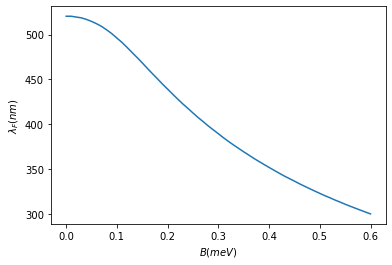

In [235]:
fermi_lambda_array = (2.*np.pi*60.583/10.)/np.array(e_B_gap[2])
plt.plot(np.arange(0, 0.61, 0.01), fermi_lambda_array)
plt.xlabel(r'$B(meV)$')
plt.ylabel(r'$\lambda_F (nm)$')

In [240]:
print(fermi_lambda_array[0]/2.)

260.23625429553437


In [ ]:
e_array2, psi_array2 = B_scan()

In [ ]:
print(np.array(e_B_gap[0]))

In [ ]:
e_B_gap = B_gap_scan(a=60.583)

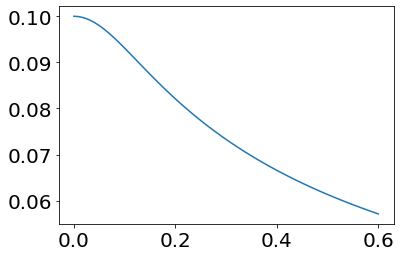

In [44]:
plt.plot(np.arange(0, 0.61, 0.01), e_B_gap[1])

[array([-0.07673202, -0.07673202,  0.07673202,  0.07673202]), array([-0.08360774, -0.06911364,  0.06911364,  0.08360774]), array([-0.06121156,  0.06121156]), array([-0.05320556,  0.05320556]), array([-0.04519159,  0.04519159]), array([-0.0372324,  0.0372324]), array([-0.02937751,  0.02937751]), array([-0.02167293,  0.02167293]), array([-0.01416716,  0.01416716]), array([-0.00691724,  0.00691724]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.05950786,  0.05950786]), array([-0.06610497,  0.06610497]), array([-0.06974982,  0.06974982]), array([-0.07155247,  0.07155247]), array([-0.0723436,  0.0723436]), array([-0.07258554,  0.07258554]), array([-0.07251599,  0.07251599]), array([-0.07226091,  0.07226091]), array([-0.07313842,  0.07313842]), array([-0.07295644, -0.07144816,  0.07144816,  0.07295644]), array([-0.07095866,  0.07095866]), array([-0.07234944, -0.07043949,  

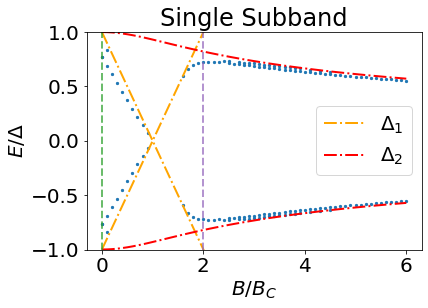

In [21]:
import pickle
e_B_trial = pickle.load(open('./Real params/Data/B_scan()', 'rb'))
print(e_B_trial)
B_plot(e_B_trial, 'test', gap_0=np.array(e_B_gap[0]), gap_k=np.array(e_B_gap[1]), title='Single Subband')
plt.axvline(0, c='#2ca02c', ls='--', alpha=0.7, lw=2)
plt.axvline(2, c='#9467bd', ls='--', alpha=0.7, lw=2)
#plt.savefig('./viva_plots/single subband E B', dpi=300, bbox_inches='tight')

# E vs L

In [182]:
def W_scan(W_array=np.arange(1, 101), a=60.583, B=0.2, mu=0., U_0=0., phi=0., salt='chizhang'):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in W_array:
        print(i)
        L = i*a
        syst = make_system_real(L=L, a=a, B=B, mu=mu, U_0=U_0, phi=phi, salt=salt)
        energies, wavefunctions = find_boundstates(syst, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [183]:
def L_plot(energy_array, figure_title, gap, W_range=[1, 101], delta=0.1, a=60.583, title=r'$B=0.2, U_0=0, \mu=0, \phi=0, \Delta=0.1, salt=chizhang$'):
    ex=[]
    ey=[]
    
    L = np.arange(W_range[0], W_range[1])*a/10.
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(L[i])
            ey.append(energy_array[i][j])
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    plt.axhline(gap/delta, color='r', ls=':')
    plt.axhline(-gap/delta, color='r', ls=':')
    plt.scatter(ex, ey, s=5)
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$L/nm$')
    plt.ylabel(r'$E/\Delta$')
    plt.ylim(-1, 1)
    plt.title(title)
    plt.savefig('./Real params/'+figure_title, dpi=300)

In [213]:
def wavefunc_visualiser(psi, index, a=60.583):
    wavefunc = psi[:, index]
    orbitals = []
    for i in range(4):
        orbitals.append(wavefunc[i::4])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
    ax1.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[0])**2.)
    ax1.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax2.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[1])**2.)
    ax2.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax3.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[2])**2.)
    ax3.set(xlabel='Junction position/nm', ylabel='Probability density')
    ax4.plot(np.arange(0, len(orbitals[0]))*a/10, np.abs(orbitals[3])**2.)
    ax4.set(xlabel='Junction position/nm', ylabel='Probability density')
    
    for i in range(4):
        print(np.sum(np.abs(orbitals[i])**2.))

In [229]:
last_time = pickle.load(open('./Keselman5/Data/W_scan(W_array=[0, 101], B=1p4, t=50, nu=2, mu=0, U_0=0, delta=1, phi=0, salt=chizhang)', 'rb'))
print(last_time[1:])

[array([-0.39699501, -0.38240521,  0.38240521,  0.39699501]), array([-0.39605105, -0.36550042,  0.36550042,  0.39605105]), array([-0.39439601, -0.34959056,  0.34959056,  0.39439601]), array([-0.39202132, -0.33599816,  0.33599816,  0.39202132]), array([-0.38884164, -0.32505298,  0.32505298,  0.38884164]), array([-0.38476186, -0.31672528,  0.31672528,  0.38476186]), array([-0.37970211, -0.31084786,  0.31084786,  0.37970211]), array([-0.37361702, -0.30720447,  0.30720447,  0.37361702]), array([-0.3665107 , -0.30556533,  0.30556533,  0.3665107 ]), array([-0.35844537, -0.30569832,  0.30569832,  0.35844537]), array([-0.3495425, -0.3073679,  0.3073679,  0.3495425]), array([-0.33997618, -0.31032783,  0.31032783,  0.33997618]), array([-0.32996028, -0.31431121,  0.31431121,  0.32996028]), array([-0.31902082,  0.31902082]), array([-0.3241231,  0.3241231]), array([-0.32925021, -0.29960062,  0.29960062,  0.32925021]), array([-0.3340147 , -0.29014189,  0.29014189,  0.3340147 ]), array([-0.33803889, 

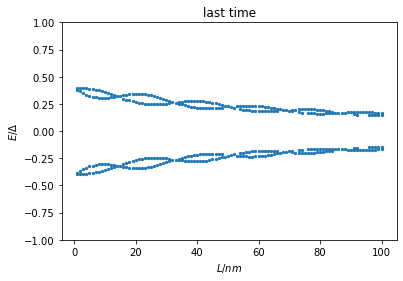

In [231]:
L_plot(last_time[1:], 'last time', 2, title='last time', a=10, delta=1.)

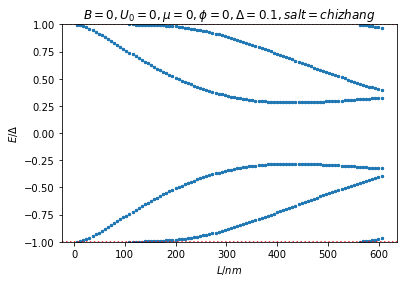

In [220]:
L_plot(e_array8, 'E vs L, a~60, B=0', np.array(e_B_gap[0])[0,1], title=r'$B=0, U_0=0, \mu=0, \phi=0, \Delta=0.1, salt=chizhang$')

In [ ]:
e_array3, psi_array3 = W_scan()

In [ ]:
e_array4, psi_array4 = W_scan(np.arange(41, 101))

In [179]:
e_array5 = np.concatenate((e_array3, e_array4))

[-0.04481747 -0.03571066  0.03571066  0.04481747]


In [253]:
syst_temp = make_system_real(L=2000, a=60.583, B=0.2, mu=0., U_0=0., phi=0., salt='chizhang')
e, psi = find_boundstates(syst_temp, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)
print(e)
print(psi.shape)

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[33, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.2, 0.0, 'chizhang']
[-0.07389292 -0.04465808  0.04465808  0.07389292]
(140, 4)


In [292]:
syst_temp = make_system_real(L=6000, a=60.583, B=0.2, mu=0., U_0=0., phi=np.pi, salt='chizhang')
e, psi = find_boundstates(syst_temp, -1.1*0.1, 1.1*0.1, rtol=1e-2*0.1)
print(e)
print(psi[:,0].shape[0]/4)

Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[99, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.2, 3.141592653589793, 'chizhang']
[-7.12130730e-02  3.51694351e-12  3.51694351e-12  7.12130730e-02]
101.0


In [255]:
print(psi[:,0].shape[0]/4)

35.0


0.13968948524126087
0.1393384114772787
0.13968948522343502
0.13933841145944476


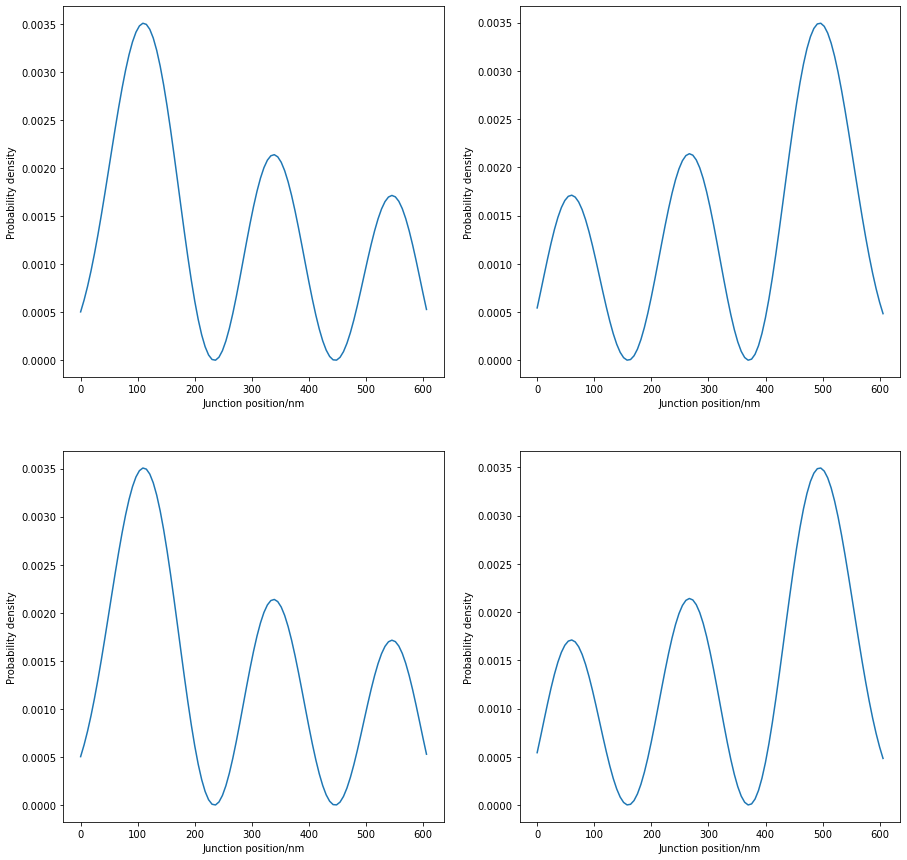

In [300]:
wavefunc_visualiser(psi, 2)

0.05205593366129856
0.05244055280300391
0.05205593366415164
0.052440552805874126


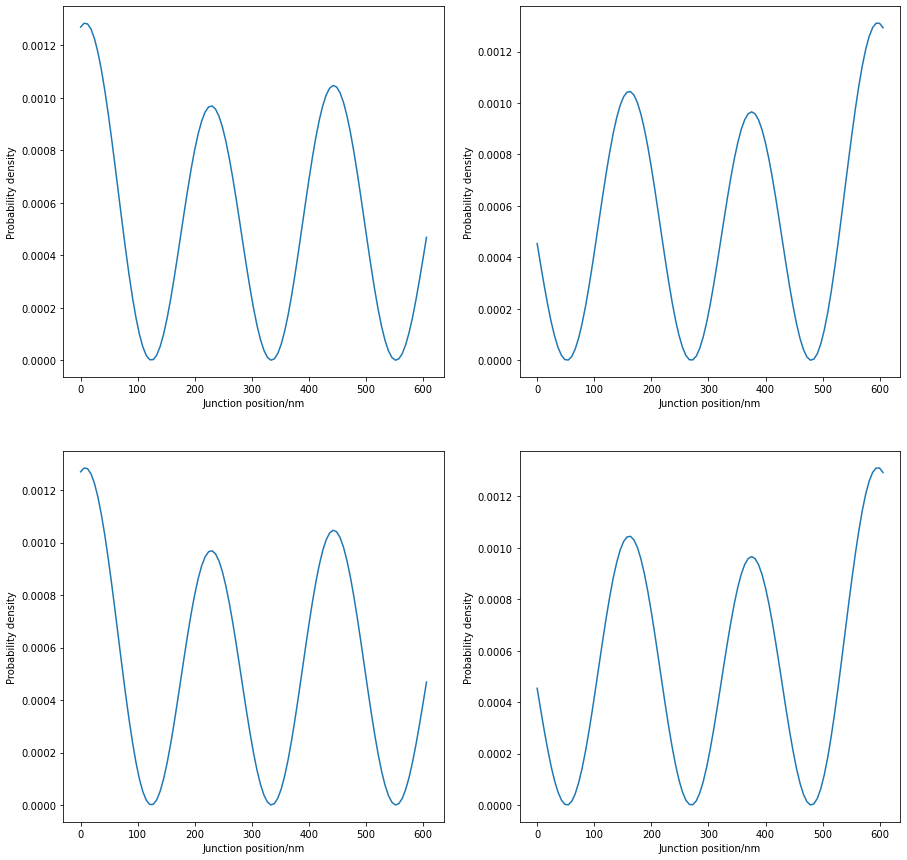

In [294]:
wavefunc_visualiser(psi, 1)

In [ ]:
e_array6, psi_array6 = W_scan(B=0.4)

In [ ]:
e_array7, psi_array7 = W_scan(B=0.6)

In [219]:
e_array8, psi_array8 = W_scan(B=0.)

1
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[1, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
[-0.09981801 -0.09981801  0.09981801  0.09981801]
2
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[2, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
[-0.09928965 -0.09928965  0.09928965  0.09928965]
3
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[3, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
[-0.09846 -0.09846  0.09846  0.09846]
4
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[4, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
[-0.09738538 -0.09738538  0.09738538  0.09738538]
5
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[5, 45.13293228464011, 1.6506280639783437, 0.0, 0.0, 0.1, 0.0, 0.0, 'chizhang']
[-0.09611983 -0.09611983  0.09611983  0.09611983]
6
Parameters: W, t, nu, mu, U_0, delta, B, phi, salt
[6, 45.13293228464011, 1.6506280639783437, 0